# Two body system

Consider a system of two bodies under gravitational attraction. The masses are $m_1,m_2$ and the gravitational constant is $\mathcal{G}$.

The generalised coordinates of the system are the polar coordinates $r,\theta$ of the body of mass $m_1$ in the reference frame centred on the centre of gravity $O$ of the two bodies ($O$ itself has a rectilinear uniform motion). The standard (Cartesian) coordinates are then given by

\begin{equation*}
x = r\cos\theta
\hspace{2cm}
y = r\sin\theta
\end{equation*}

By construction, the polar coordinates of the other body are $\frac{m_1}{m_2}r,-\theta$, and the distance between the two bodies is therefore given by $r(1+\frac{m_1}{m_2})$. Hence, the gravitational force exerted on $m_1$ (by $m_2$) is

\begin{equation*}
F = -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2r^2}
\left(\begin{array}{l}\cos\theta\\ \sin\theta\end{array}\right) = -\nabla V
\hspace{1cm}\textrm{with}\hspace{1cm}
V \triangleq -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2}\frac{1}{r}
\end{equation*}

Hence the Lagrangian

\begin{equation*}
\mathcal{L} = m_1(\frac{1}{2}(\dot{r}^2+r^2\dot{\theta}^2)+\frac{a}{r})
\hspace{1cm}\textrm{with}\hspace{1cm}
a \triangleq \frac{\mathcal{G}m_2}{(1+\frac{m_1}{m_2})^2}
\end{equation*}

Introducing the intermediary variable $q=r^2\dot{\theta}$ (angular momentum), the equations of the dynamics are given by:

\begin{equation*}
\left\{
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\dot{\theta} & = & \frac{q}{r^2}\\
& \dot{q} & = & 0\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{r}} = \frac{\partial\mathcal{L}}{\partial r}\right]
\hspace{1cm} &
\ddot{r} & = & \frac{q^2}{r^3}-\frac{a}{r^2}
\end{array}
\right.
\end{equation*}

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab nbagg
# for better display performance, use default backend

import logging
logger = logging.getLogger()

from functools import partial
from ipyshow.odesimu.system import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## G2body class

In [2]:
#----------------------------------------------------------------------------------------------------
class G2body (System):
#----------------------------------------------------------------------------------------------------

    shadowshape = (4,)
    
    def __init__(self,M1,M2,G):
        self.M1,self.M2,self.G = M1, M2, G
        self.a = G*M2/square(1+M1/M2)
        def main(t,state,a=self.a):
            r,theta,dr,r2dtheta = state
            r2 = square(r)
            dtheta = r2dtheta/r2
            ddr = (square(r2dtheta)/r-a)/r2
            return array((dr,dtheta,ddr,0))
        self.main = main
        def jac(t,state,a=self.a):
            r,theta,dr,r2dtheta = state
            r2 = square(r)
            r3 = r*r2
            q2 = square(r2dtheta)
            return array((
                (0,0,1,0),
                (-2*r2dtheta/r3,0,0,1/r2),
                ((-3*q2/r+2*a)/r3,0,0,2*r2dtheta/r3),
                (0,0,0,0),
                ))
        self.jacobian = jac
        def analytics(state,a=self.a):
            r,theta,dr,r2dtheta = state
            K = square(dr)+square(r2dtheta/r)-2*a/r
            p = square(r2dtheta)/a
            e = sqrt(1+K*p/a)
            a = arcsin(dr*r2dtheta/(a*e))
            if p<r: a=pi-a
            phi = theta-a
            return p,e,phi,K,r2dtheta
        self.analytics = analytics
        def fordisplay(state,t=M1/M2):
            r,theta,dr,r2dtheta = state
            x,y = r*cos(theta),r*sin(theta)
            live = x,y,-t*x,-t*y
            return live, live
        self.fordisplay = fordisplay

    Help = '''
        /M1,M2 [kg]: masses of the two bodies
        /G [m^3.kg^-1.sec^-2]: gravitation constant
    '''

    def display(self,ax,refsize=100.,ini=None,**ka):
        m1,m2 = self.M1,self.M2
        ratio = clip(sqrt(m1/m2),1./refsize,refsize)
        sz = (refsize*ratio,refsize/ratio)
        diag_l, = ax.plot((),(),'k',ls=':')
        diag_s = ax.scatter((),(),s=sz,marker='o',c=('r','b'))
        tail_l = ax.plot((),(),'r',(),(),'b')
        p,e,phi,K,q = self.analytics(ini)
        if e<1:
            from matplotlib.patches import Ellipse
            u = 1-square(e)
            A,B = p/u,p/sqrt(u)
            c = -e*A*array((cos(phi),sin(phi)))
            T = 2*pi*A*B/q
            ax.add_patch(Ellipse(c,2*A,2*B,phi/pi*180,lw=1,color='k',fill=False,ls='dashed'))
            rmax = 1.1*p/(1-e)
            if m2<m1: rmax *= m1/m2
            ax.set_xlim(-rmax,rmax)
            ax.set_ylim(-rmax,rmax)
            resize = (lambda x,y: None)
        elif e==-1:
            T = nan
            def resize(x,y):
                ax.relim()
                ax.autoscale_view()
        else:
            c = e*p/(square(e)-1)*array((cos(phi),sin(phi)))
            h = arccos(-1/e)
            asymp_l, = ax.plot((),(),'k',ls='--')
            T = nan
            def resize(x,y,cx=c[0],cy=c[1],a00=sin(phi-h),a01=cos(phi-h),a10=sin(phi+h),a11=cos(phi+h)):
                xc = x-cx; yc = y-cy
                d = xc*a00-yc*a01,xc*a10-yc*a11,
                d,a0,a1 = (d[0],a00,a01) if abs(d[1])>abs(d[0]) else (d[1],a10,a11)
                asymp_l.set_data((c[0],x-d*a0),(c[1],y+d*a1))
                ax.relim()
                ax.autoscale_view()
        ax.set_title('trajectory:ConicSection($e$={:.2f}) period:{:.2f}'.format(e,T))
        def disp(t,live,tail):
            x1,y1,x2,y2 = live
            diag_l.set_data((x1,x2),(y1,y2))
            diag_s.set_offsets(((x1,y1),(x2,y2)))
            tail_l[0].set_data(tail[:,0],tail[:,1])
            tail_l[1].set_data(tail[:,2],tail[:,3])
            resize(x1,y1)
        return super().display(ax,disp,ini=ini,**ka)

    @staticmethod
    def makestate(r=0.,theta=0.,dr=0.,dtheta=0.,q=pi/180.):
        return array((r,theta*q,dr,square(r)*dtheta*q))

    Help += '''
        makestate/r [m]: distance of 1st body from centre of gravity
        makestate/dr [m.sec^-1]: speed of 1st body towards (or away from) centre of gravity
        makestate/theta [deg]: angle of axis between the two bodies with reference, represented as horizontal rightward from centre of gravity
        makestate/dtheta [deg.sec^-1]: angular speed of theta
        launch/refsize [pt^2]: average size (area) of the bobs for display (attempts to reflect mass ratio)
    '''

    launchdefaults = System.launchdefaults.copy()
    launchdefaults.update(
        taild=10,
        hooks=(partial(logger_hook,logger=logger),),
    )

    Help += System.Help

In [3]:
G2body.helper()

<IPython.core.display.Javascript object>


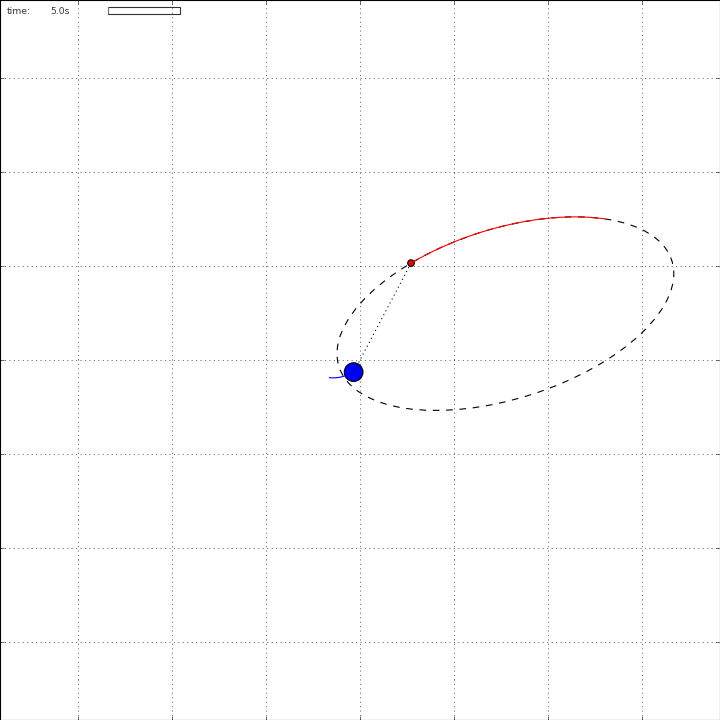

In [4]:
logger.setLevel(logging.WARN) # can be changed dynamically by logger_hook
syst = G2body(G=1,M1=10,M2=80); ini = dict(r=15.,dr=-1.,dtheta=3.,theta=30.)
syst.launch(ini=syst.makestate(**ini))

Trajectory
----------

The law of conservation of energy yields $\dot{r}^2=K-\frac{q^2}{r^2}+\frac{2a}{r}$ for some constant $K$ (total energy) and, using $\dot{\theta}=\frac{q}{r^2}$ and $\frac{\mathbf{d}r}{\mathbf{d}\theta}=\frac{\dot{r}}{\dot{\theta}}$, one gets

\begin{equation*}
(\frac{\mathbf{d}r}{\mathbf{d}\theta})^2 = r^2(\frac{K}{q^2}r^2+2\frac{a}{q^2}r-1)
\hspace{1cm}
\textrm{with initial conditions}
\hspace{1cm}
r|_{\theta_0} = r_0
\textrm{ and }
\frac{\mathbf{d}r}{\mathbf{d}\theta}|_{\theta_0}=\frac{\dot{r}_0r_0^2}{q}
\end{equation*}

One solution is given by

\begin{equation*}
r = \frac{p}{1+e\cos(\theta-\phi)}
\hspace{1cm}\textrm{with}\hspace{1cm}
p\triangleq\frac{q^2}{a}
\textrm{ and }
e\triangleq\sqrt{1+\frac{Kq^2}{a^2}}
\textrm{ and }
\left|
\begin{array}{l}
\sin(\theta_0-\phi)\triangleq\frac{q\dot{r}_0}{ae}\\
\cos(\theta_0-\phi)\triangleq\frac{p-r_0}{er_0}
\end{array}
\right.
\end{equation*}

The presence of two (consistent) initial conditions compensate for the unknown sign of  $\frac{\mathbf{d}r}{\mathbf{d}\theta}$, so that the system is deterministic (unique solution), hence the trajectory above is the only possible one. It is a conic section (ellipse if $e\lt1$, parabola if $e=1$, hyperbola if $e\gt1$) with the origin $O$ as focus. The initial conditions define the values of $q,K$, and hence those of $p,e,\phi$ (by construction, the equations defining $\phi$ have a unique solution modulo $2\pi$). 

Periodicity
-----------

In the case of an ellipse, the motion is periodic and the period is given by

\begin{equation*}
T = \int_0^{2\pi}\frac{r^2}{q}\mathbf{d}\theta=\frac{\mathcal{2A}}{q}
\end{equation*}

where $\mathcal{A}$ is the area of the ellipse. Using the change of variable $t=\tan\frac{\theta}{2}$:

\begin{equation*}
\mathcal{A} = \int_0^{2\pi}\frac{p^2}{2(1+e\cos\theta)^2}\mathbf{d}\theta =
\int_0^{\pi}\frac{p^2}{(1+e\cos\theta)^2}\mathbf{d}\theta =
2p^2\int_0^\infty\frac{\mathbf{d}t}{(1+t^2)(1+e\frac{1-t^2}{1+t^2})^2}
\end{equation*}

Simplifying the algebraic fraction in the integrand, we get

\begin{equation*}
\mathcal{A} = \frac{2p^2}{(1-e)^2}\int_0^\infty\frac{1+t^2}{(c+t^2)^2}\mathbf{d}t
\hspace{1cm}\textrm{with}\hspace{1cm}
c\triangleq\frac{1+e}{1-e}
\end{equation*}

Now, the integrand can be rewritten as

\begin{equation*}
\frac{1+t^2}{(c+t^2)^2} = \frac{1-c}{2c}\frac{c-t^2}{(c+t^2)^2}+\frac{1+c}{2c}\frac{1}{c+t^2}\\
\textrm{where } \int_0^\infty\frac{c-t^2}{(c+t^2)^2}\mathbf{d}t=[\frac{t}{c+t^2}]_0^\infty=0\\
\textrm{and } \int_0^\infty\frac{1}{c+t^2}\mathbf{d}t=\frac{1}{\sqrt{c}}\int_0^\infty\frac{\mathbf{d}t}{1+t^2}=\frac{1}{\sqrt{c}}[\arctan t]_0^\infty=\frac{\pi}{2\sqrt{c}}
\end{equation*}

Hence we have $\int_0^\infty\frac{1+t^2}{(c+t^2)^2}\mathbf{d}t=\frac{\pi(1+c)}{4c\sqrt{c}}$. Reporting in $\mathcal{A}$ and simplifying, we get

\begin{equation*}
\mathcal{A} = \frac{\pi p^2}{(1-e^2)\sqrt{1-e^2}}
\end{equation*}